In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None) # will display full text in row
from collections import defaultdict
import numpy as np
import os, re, string
from time import time
import tensorflow as tf
import nltk
#nltk.download(['punkt', 'stopwords', 'averaged_perceptron_tagger', 'wordnet'], quiet=True)
from transformers import pipeline
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from rouge import Rouge
from clean_text import clean_text
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Get IMDB Movie Review dataset

In [2]:
# data stored locally, alternatively use function under .utils.download_imdb_data()
orig = pd.read_csv('../datasets/IMDB Dataset.csv')

In [3]:
print(orig.shape)

(50000, 2)


#### Restrict to data subset (n=5000)

In [4]:
orig = orig.sample(n=5000, random_state=999).reset_index(drop=True)

## Clean data

We'll create three versions of cleaned reviews: one that only converts numbers to words, removes sentence breaks, and small grammatical errors. This version leaves punctuation. A second version performs these modifications, but also removes stop words, punctuation, and lemmatizes words. Both versions lowercase all words for consistency. Finally, a third version that removes extremely infrequent words, defined as those only present once in the corpus (e.g. misspellings).

In [5]:
orig.rename(columns={'review': 'orig'}, inplace=True)

In [6]:
processed = pd.DataFrame(clean_text().run(orig['orig'], no_stop_words=False, 
                         remove_punctuation=False, lemmatize=False).rename('clean')) # returns pd.Series

In [7]:
print(orig['orig'][0])

MST 3000 should do this movie. It is the worst acted movie I have ever seen. First of all, you find out that the shooter has no bank account and no history since leaving the army in 1993 and pays his rent in cash. There is no way in hell that a person like that would ever be allowed to be that close to a president not to mention a high profile job. Also, the head of security for the POTHUS would not be so emotional that he would start drinking into a haze if the president was shot. This movie sucked. I cannot express the extremite that this movie was. Every single actor was terrible. Even the chick at the trailer park. I crap on this garbage. What a waste of time.


In [8]:
print(processed['clean'][0])

mst three thousand should do this movie. it is the worst acted movie i have ever seen. first of all, you find out that the shooter has no bank account and no history since leaving the army in one thousand, nine hundred and ninety-three and pays his rent in cash. there is no way in hell that a person like that would ever be allowed to be that close to a president not to mention a high profile job. also, the head of security for the pothus would not be so emotional that he would start drinking into a haze if the president was shot. this movie sucked. i cannot express the extremite that this movie was. every single actor was terrible. even the chick at the trailer park. i crap on this garbage. what a waste of time.


In [9]:
# Remove stop words, punctuation, and lemmatize (which takes some time)
start = time()
processed['cleaner'] = clean_text().run(orig['orig'], no_stop_words=True, remove_punctuation=True, lemmatize=True)
print('Total time:', round(time() - start, 0), 'seconds')

Total time: 109.0 seconds


In [10]:
processed['cleaner'][0]

'mst three thousand movie bad act movie ever see first find shooter bank account history since leave army one thousand nine hundred ninety-three pay rent cash way hell person like would ever allow close president mention high profile job also head security pothus would emotional would start drinking haze president shot movie suck can not express extremite movie every single actor terrible even chick trailer park crap garbage waste time'

### Remove words only present once in corpus (e.g. misspellings)

In [11]:
def count_word_freq(series):
    '''
    Counts word frequency across all documents (rows) in a pd.Series.
    :param series: pd.Series
    :returns: pd.DataFrame, where index is each unique word in corpus and column is count of
        the occurrence of that word across all documents.
    '''
    temp = [i.split() for i in series] 
    freq = defaultdict(int)  # Get freq of each word across all documents
    for indiv_doc in temp:
        for token in indiv_doc:
            freq[token] += 1
        
    word_freq = pd.DataFrame.from_dict(freq, orient='index')\
        .reset_index().rename(columns={'index': 'word', 0: 'freq'})
    return word_freq

In [12]:
word_freq = count_word_freq(processed['cleaner'])

In [13]:
print(word_freq['freq'].describe())

count    32080.000000
mean        18.530393
std        136.825197
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      10438.000000
Name: freq, dtype: float64


In [14]:
print(f"Number of words that appear only once in corpus: {len(word_freq[word_freq['freq']==1])}")

Number of words that appear only once in corpus: 13728


In [15]:
print('Some examples of rare words:')
word_freq[word_freq['freq']==1]['word'].head(20)

Some examples of rare words:


39            pothus
49         extremite
102     jealousblind
156     miscalculate
183      reintroduce
226           tardis
312         hartnell
314          davison
420           pimped
454    entertainerer
457        entourage
469           spicey
534          trimspa
535      spokeswoman
610          mcquaid
704           survey
710       bulldosers
713          clocked
719         vaporize
726              yds
Name: word, dtype: object

In [16]:
processed['cleanest'] = clean_text().remove_infreq_words(processed['cleaner'], 1)

In [17]:
count_word_freq(processed['cleanest']).describe()

,freq
count,18352.000000
mean,31.643799
std,179.789204
min,2.000000
25%,3.000000
50%,5.000000
75%,15.000000
max,10438.000000


## TF-IDF

[Term frequency-inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a statistic reflecting a given word's importance to a particular document in a collection of documents (i.e. a corpus). This statistic is bounded between 0 and 1, with higher scores indicating a given word is comparably rarer (i.e. more salient) in a particular document. This metric is commonly used to extract keywords about a text.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [19]:
vectors = vectorizer.fit_transform(processed['cleanest'].tolist()) # scipy.sparse.csr.csr_matrix
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

In [20]:
# Lookup dict for each document's words
# Note - sklearn's TfidfVectorizer smoothes the IDF function, resulting in fewer words per document than orig
start = time()
tfidf_dict = {}
tfidf_values = []
for doc in range(len(denselist)):
    positions = [idx for idx, val in enumerate(denselist[doc]) if val > 0] # get index if word in document, i.e. > 0 tf-idf
    values = [val for val in denselist[doc] if val > 0] # tf-idf values in doc
    words = [feature_names[i] for i in positions] # words themselves
    tfidf_dict[doc] = dict(zip(words, values))
    tfidf_values += values # TF-IDF values for all words in all documents
print('Total time:', round(time() - start, 0), 'seconds')

Total time: 9.0 seconds


In [21]:
tfidf_dict[0]

{'account': 0.15766166445475302,
 'act': 0.0631071731794978,
 'actor': 0.07195756500365545,
 'allow': 0.12642768778107846,
 'also': 0.06582671238885487,
 'army': 0.1486779297667666,
 'bad': 0.06001576512279624,
 'bank': 0.15360171138437043,
 'can': 0.07702125597433372,
 'cash': 0.1486779297667666,
 'chick': 0.15054303421604515,
 'close': 0.1103306922924321,
 'crap': 0.11801920613037656,
 'drinking': 0.16395475050508776,
 'emotional': 0.13564047385226868,
 'even': 0.05707535849271671,
 'ever': 0.14436002222215766,
 'every': 0.0821284310697787,
 'express': 0.15584783682451311,
 'find': 0.07659182172100361,
 'first': 0.06435971125154062,
 'garbage': 0.13891457649771943,
 'haze': 0.20821389087071354,
 'head': 0.10175683055069308,
 'hell': 0.11588637406900638,
 'high': 0.09744766228492414,
 'history': 0.11588637406900638,
 'hundred': 0.08741618062667532,
 'job': 0.09730806934516623,
 'leave': 0.10849309034577867,
 'like': 0.04688748543666598,
 'mention': 0.10912772812847131,
 'movie': 0.156

In [22]:
# Top 5 most important words according to TF-IDF of first document
dict(sorted(tfidf_dict[0].items(), key=lambda item: item[1], reverse=True)[:5])

{'president': 0.3178819065171155,
 'shooter': 0.21245299604104773,
 'haze': 0.20821389087071354,
 'mst': 0.20130280690080174,
 'profile': 0.20130280690080174}

In [23]:
len(tfidf_values)

452315

### Distribution of TF-IDF values

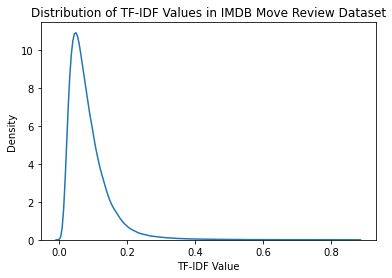

In [24]:
sns.kdeplot(tfidf_values)
plt.xlabel('TF-IDF Value')
plt.title("Distribution of TF-IDF Values in IMDB Move Review Dataset")
plt.show()

In [25]:
pd.Series(tfidf_values).describe()

count    452315.000000
mean          0.085898
std           0.060628
min           0.004709
25%           0.046514
50%           0.070770
75%           0.107240
max           0.871732
dtype: float64

### Restrict to top *n* keywords

In [26]:
def top_n_keywords(dictionary, n=10):
    '''
    Restricts to top n most important words per document, returning this as pd.Series
    :param dictionary: dict, tf-idf dictionary where each subdictionary pertains to an individual document
    :param n: int, number of top keywords to limit to
    :returns: pd.Series
    '''
    key_wds = []
    for i in range(len(dictionary)):
        key_wds.append(list(dict(sorted(dictionary[i].items(), key=lambda item: item[1], reverse=True)[:n]).keys()))
    return pd.Series(key_wds)

In [27]:
processed['tfidf_top10'] = top_n_keywords(tfidf_dict, n=10)

In [28]:
def top_n_values(dictionary, n=10):
    '''
    Gets TF-IDF values among top n most important words
    :dictionary: dict, tf-idf dictionary where each 
    '''
    vals = []
    for i in range(len(dictionary)):
        vals += list(dict(sorted(dictionary[i].items(), key=lambda item: item[1], reverse=True)[:n]).values())
    return pd.Series(vals)

In [29]:
top_n_values(tfidf_dict, n=10).describe()

count    49994.000000
mean         0.207826
std          0.083977
min          0.068449
25%          0.156373
50%          0.185607
75%          0.232197
max          0.871732
dtype: float64

### Filter top keywords using minimum TF-IDF score

As indicated above, some of the top 10 keywords have low TF-IDF scores, meaning few of the words in a given review are meaningful according to this metric. To remove these, the function below defines keywords based on a percentile of the TF-IDF distribution

In [30]:
def filter_top_keywords(dictionary, filter_val=0.2, max_keywords=10):
    filtered_words = []
    for i in range(len(dictionary)):
        words = [key for key, val in dictionary[i].items() if val > filter_val]
        if len(words) == 0: # Take top words if none meet threshold
            words = list(dict(sorted(dictionary[i].items(), key=lambda item: item[1], reverse=True)[:1]).keys())
        words = words[:max_keywords]
        filtered_words.append(words)
    return pd.Series(filtered_words)

In [31]:
filter_val = np.percentile(pd.Series(tfidf_values), 90)
processed['tfidf_90pct'] = filter_top_keywords(tfidf_dict, filter_val=filter_val)

In [32]:
processed['tfidf_90pct'].apply(lambda x: len(x)).describe()

count    5000.000000
mean        7.651600
std         2.525449
min         1.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        10.000000
Name: tfidf_90pct, dtype: float64